In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv("/content/heart-disease.csv")

In [4]:
#Veriye genel bakış
def check_df(dataframe):
  print("################### Shape ##################")
  print(dataframe.shape)
  print("################### Types ##################")
  print(dataframe.info())
  print("################### Head ##################")
  print(dataframe.head())
  print("################### Tail ##################")
  print(dataframe.tail())
  print("################### NA ##################")
  print(dataframe.isnull().sum())
  print("################### Quantiles ##################")
  print(dataframe.describe([0, 0.25, 0.50, 0.75, 0.99, 1]).T)

check_df(df)

################### Shape ##################
(303, 14)
################### Types ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
################### Head ##################
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak

14 değişken ve 303 değerimiz vardır.

Değişkenlerin türü oldpeak hariç int64 türündedir.

NAN(Boş) değerimiz yoktur.

Çeyrekliklerimize bakarak bazı aykırı değerleri görebiliriz. Örn: chol, oldpeak

In [5]:
#Değişken türlerini belirliyoruz.
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]

  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" ]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols,num_but_cat

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 303
Variables: 14
cat_cols: 9
num_cols: 5
cat_but_car: 0
num_but_cat: 9


In [6]:
print(cat_cols)
print(num_cols)

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


     sex  Ratio
sex            
1    207 68.317
0     96 31.683
################################################


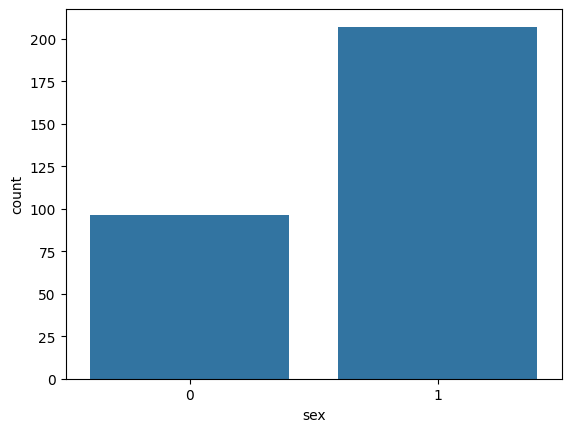

     cp  Ratio
cp            
0   143 47.195
2    87 28.713
1    50 16.502
3    23  7.591
################################################


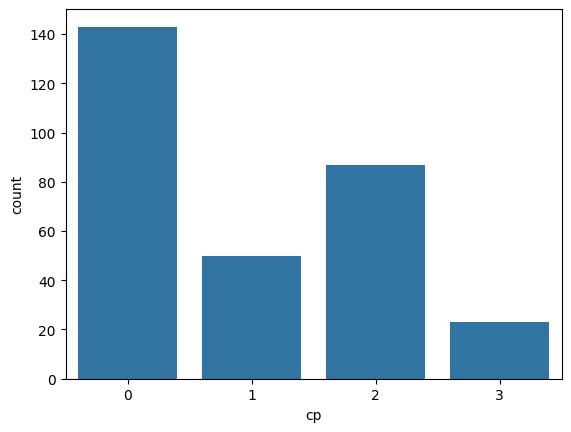

     fbs  Ratio
fbs            
0    258 85.149
1     45 14.851
################################################


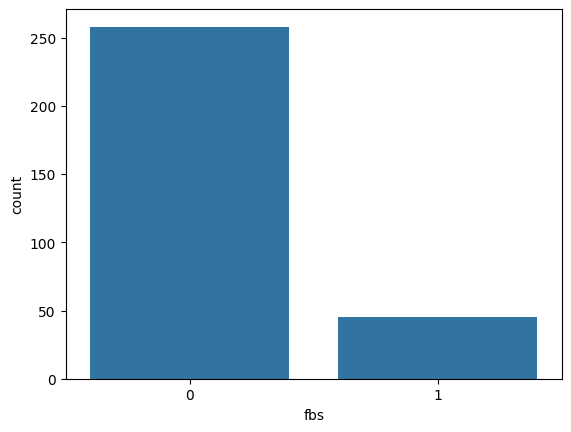

         restecg  Ratio
restecg                
1            152 50.165
0            147 48.515
2              4  1.320
################################################


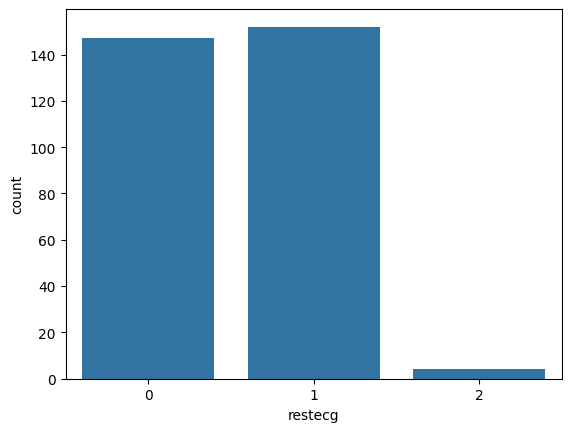

       exang  Ratio
exang              
0        204 67.327
1         99 32.673
################################################


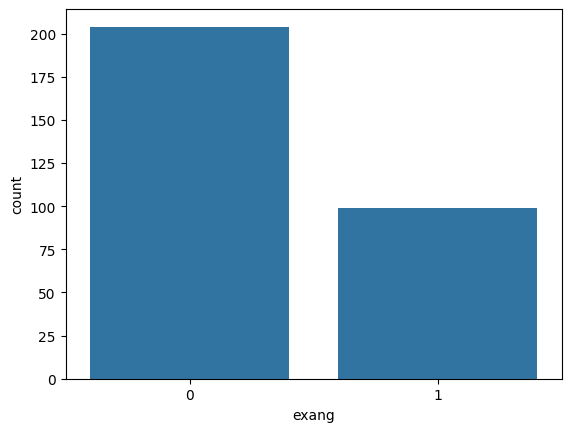

       slope  Ratio
slope              
2        142 46.865
1        140 46.205
0         21  6.931
################################################


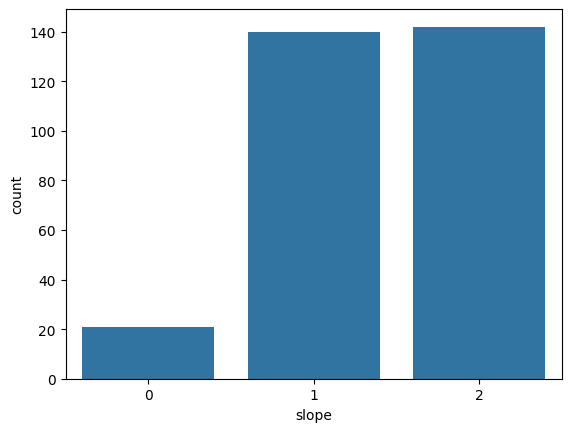

     ca  Ratio
ca            
0   175 57.756
1    65 21.452
2    38 12.541
3    20  6.601
4     5  1.650
################################################


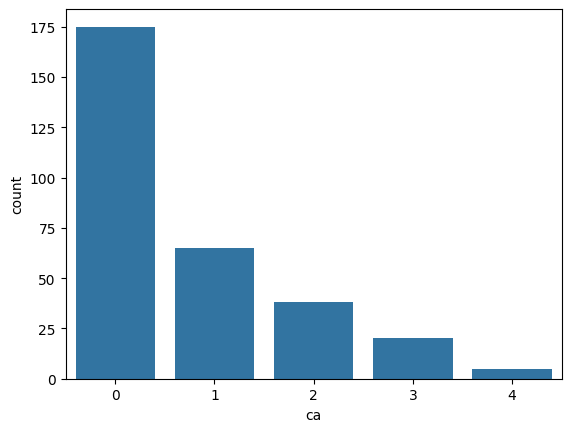

      thal  Ratio
thal             
2      166 54.785
3      117 38.614
1       18  5.941
0        2  0.660
################################################


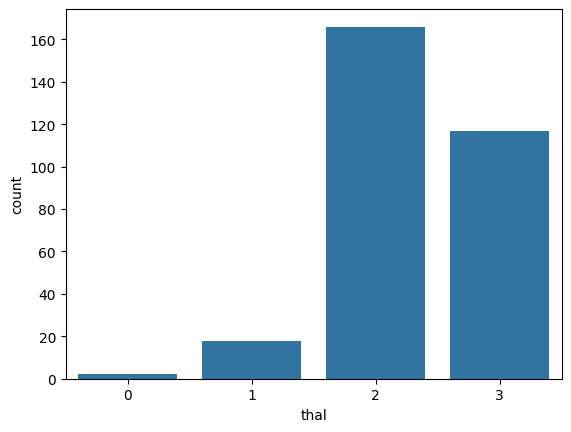

        target  Ratio
target               
1          165 54.455
0          138 45.545
################################################


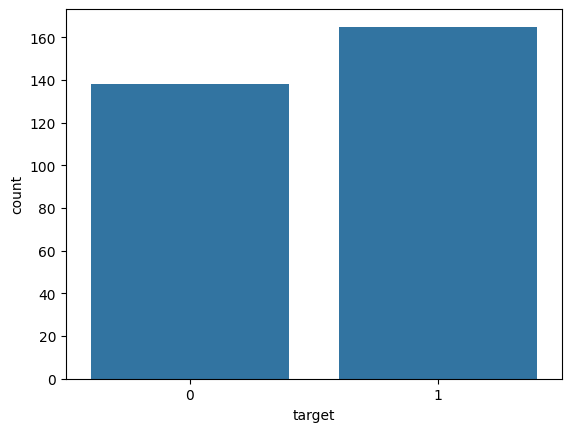

In [7]:
#Kategorik değişken analizi
def cat_summary(dataframe, col_name, plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100*dataframe[col_name].value_counts() / len(dataframe)}))
  print("################################################")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show(block=True)

for col in cat_cols:
  cat_summary(df, col, plot=True)

count   303.000
mean     54.366
std       9.082
min      29.000
5%       39.100
10%      42.000
20%      45.000
30%      50.000
40%      53.000
50%      55.000
60%      58.000
70%      59.000
80%      62.000
90%      66.000
95%      68.000
99%      71.000
max      77.000
Name: age, dtype: float64


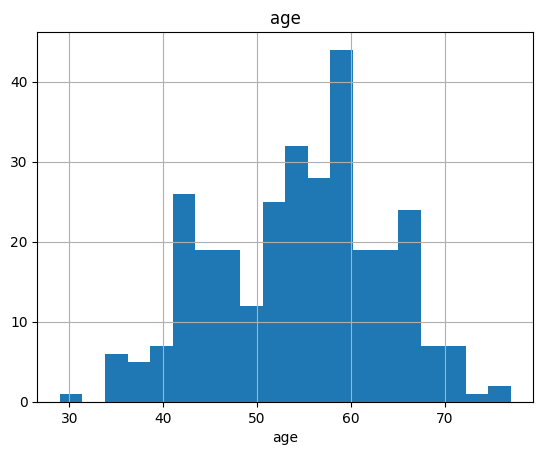

count   303.000
mean    131.624
std      17.538
min      94.000
5%      108.000
10%     110.000
20%     120.000
30%     120.000
40%     126.000
50%     130.000
60%     134.000
70%     140.000
80%     144.000
90%     152.000
95%     160.000
99%     180.000
max     200.000
Name: trestbps, dtype: float64


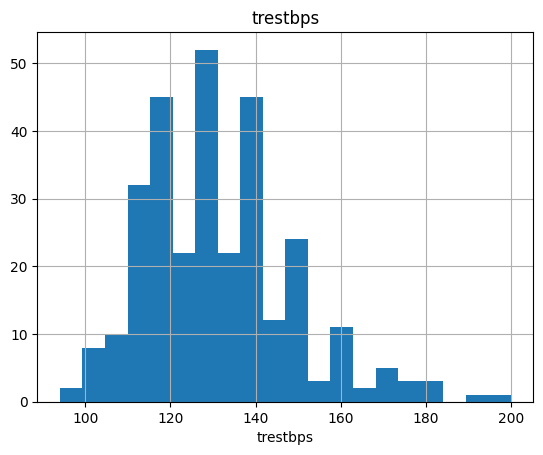

count   303.000
mean    246.264
std      51.831
min     126.000
5%      175.000
10%     188.000
20%     204.000
30%     217.600
40%     230.000
50%     240.000
60%     254.000
70%     268.000
80%     285.200
90%     308.800
95%     326.900
99%     406.740
max     564.000
Name: chol, dtype: float64


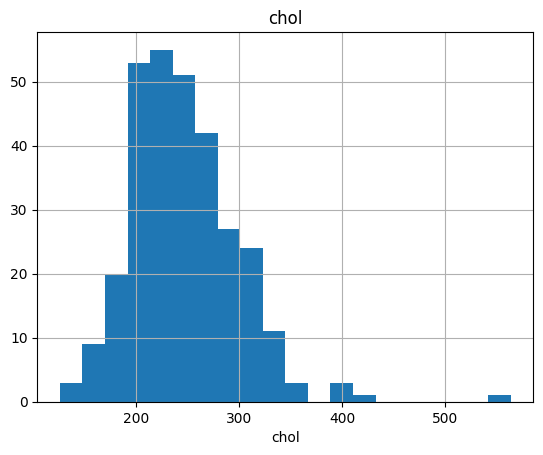

count   303.000
mean    149.647
std      22.905
min      71.000
5%      108.100
10%     116.000
20%     130.000
30%     140.600
40%     146.000
50%     153.000
60%     159.000
70%     163.000
80%     170.000
90%     176.600
95%     181.900
99%     191.960
max     202.000
Name: thalach, dtype: float64


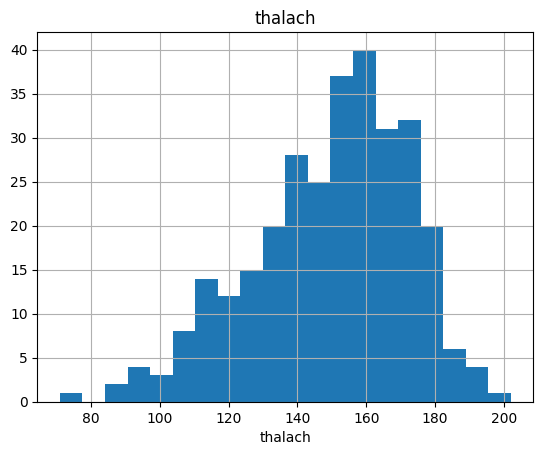

count   303.000
mean      1.040
std       1.161
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.380
50%       0.800
60%       1.120
70%       1.400
80%       1.900
90%       2.800
95%       3.400
99%       4.200
max       6.200
Name: oldpeak, dtype: float64


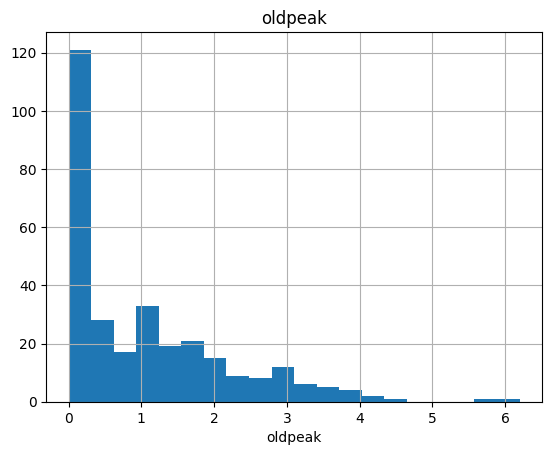

In [8]:
#Numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show(block=True)

for col in num_cols:
  num_summary(df, col, plot=True)

In [9]:
#Hedef değişkenin kategorik değişkenler ile analizi
def target_vs_cat(dataframe, target, categorical_col):
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
  print("###################################")

for col in cat_cols:
  target_vs_cat(df, "target", col)

     TARGET_MEAN
sex             
0          0.750
1          0.449


###################################
    TARGET_MEAN
cp             
0         0.273
1         0.820
2         0.793
3         0.696


###################################
     TARGET_MEAN
fbs             
0          0.550
1          0.511


###################################
         TARGET_MEAN
restecg             
0              0.463
1              0.632
2              0.250


###################################
       TARGET_MEAN
exang             
0            0.696
1            0.232


###################################
       TARGET_MEAN
slope             
0            0.429
1            0.350
2            0.754


###################################
    TARGET_MEAN
ca             
0         0.743
1         0.323
2         0.184
3         0.150
4         0.800


###################################
      TARGET_MEAN
thal             
0           0.500
1           0.333
2           0.783
3           0.239


####

In [10]:
#Hedef değişkenin numerik değişkenlere göre analizi.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "target", col)

          age
target       
0      56.601
1      52.497


        trestbps
target          
0        134.399
1        129.303


          chol
target        
0      251.087
1      242.230


        thalach
target         
0       139.101
1       158.467


        oldpeak
target         
0         1.586
1         0.583




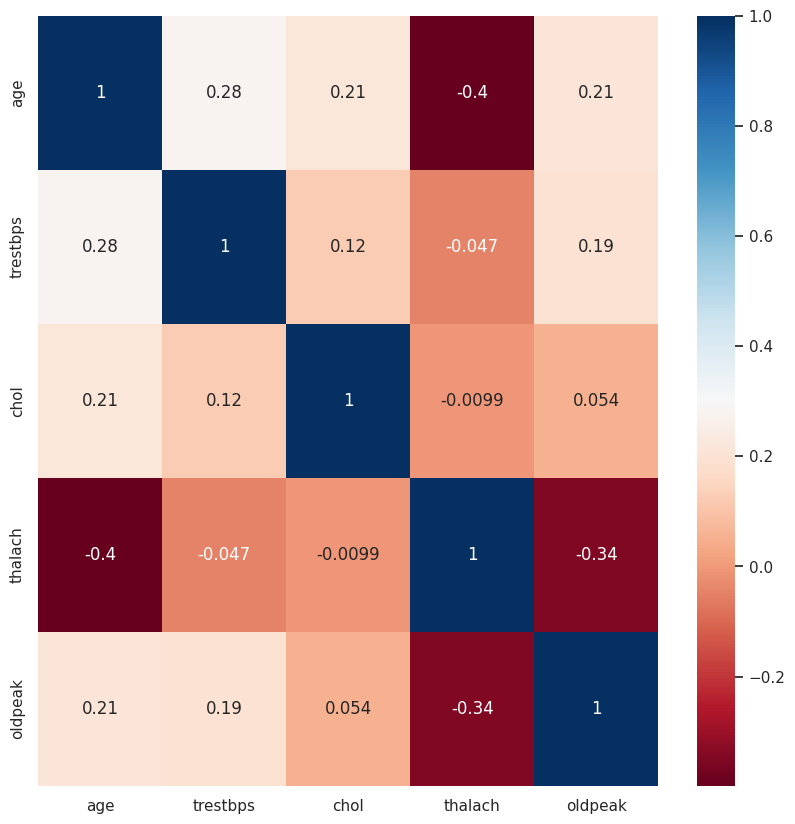

In [11]:
#Korelasyon analizi
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (10,10)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

In [12]:
#Aykırı değer analizi
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5*interquantile_range
  low_limit = quartile1 - 1.5*interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

for col in num_cols:
    print(col, check_outlier(df, col))

age False
trestbps True
chol True
thalach True
oldpeak True


In [13]:
#Aykırı değerleri baskılıyoruz.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

age False
trestbps False
chol False
thalach False
oldpeak False


In [14]:
cat_cols = [col for col in cat_cols if col not in ["target"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [15]:
#Veri setindeki değerleri modelimizin okuyabiliceği şekile getiriyoruz.
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,age,trestbps,chol,thalach,oldpeak,target,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,0.952,0.829,-0.256,0.014,1.151,1,True,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False
1,-1.915,-0.077,0.102,1.642,2.234,1,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False
2,-1.474,-0.077,-0.866,0.982,0.339,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
3,0.180,-0.681,-0.192,1.246,-0.202,1,True,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False
4,0.290,-0.681,2.293,0.586,-0.383,1,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False
5,0.290,0.527,-1.119,-0.074,-0.563,1,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False
6,0.180,0.527,1.029,0.146,0.249,1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
7,-1.143,-0.681,0.376,1.026,-0.924,1,True,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True
8,-0.261,2.339,-0.972,0.542,-0.473,1,True,False,True,False,True,True,False,False,False,True,False,False,False,False,False,False,True
9,0.290,1.131,-1.625,1.070,0.519,1,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False


In [16]:
dff = df.copy()

In [17]:
y = dff["target"]
X = dff.drop("target", axis=1)

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=156)

models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('Adaboost', AdaBoostClassifier()),
          ("XGBoost", XGBClassifier(objective='reg:squarederror')),
          ("CatBoost", CatBoostClassifier(verbose=False))]

for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

LR: (0.950820)
KNN: (0.885246)
CART: (0.770492)
RF: (0.885246)
GBM: (0.868852)
Adaboost: (0.901639)
XGBoost: (0.836066)
CatBoost: (0.950820)


In [18]:
#Kullanacağımız modeli kuruyoruz
y = df["target"]
X = df.drop(["target"], axis = 1)

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=156)

LR_model = LogisticRegression(random_state=156).fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.9508196721311475

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.97      0.94      0.95        31

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [20]:
y_pred = LR_model.predict(X)

In [21]:
y_pred[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
y[0:10]

,target
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1
